# <center> Маркетинговая аналитика приложения Procrastinate Pro+ 
<center> Автор материала: Толстошеева Татьяна (@tsheeva)

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Загрузка данных

In [1]:
# Импортируем нужные библиотеки, загрузим данные и преобразуем значения в столбцах.
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

В нашем распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

In [2]:
path_to_db = '/datasets/'

visits, orders, costs = (
    pd.read_csv(path_to_db + 'visits_info_short.csv'),  # журнал сессий
    pd.read_csv(path_to_db +'orders_info_short.csv'),  # покупки
    pd.read_csv(path_to_db +'costs_info_short.csv'),  # траты на рекламу
)

visits.name = "visits"
orders.name = 'orders'
costs.name = 'costs'

data_list = [visits, orders, costs] 

**Описание данных:**

Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

In [3]:
# Выводим общую информацию и первые строки датафреймов:
for i in data_list:
    print (i.name)
    print()
    print(i.info(memory_usage='deep'))
    print('________________________________________________')
    print()

visits

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 104.9 MB
None
________________________________________________

orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.5 MB
None
_______________________________________________

In [4]:
for i in data_list:
    print(i.name)
    print()
    print(i.isna().sum())
    print('______________________________________________________________________')
    print()

visits

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
______________________________________________________________________

orders

User Id     0
Event Dt    0
Revenue     0
dtype: int64
______________________________________________________________________

costs

dt         0
Channel    0
costs      0
dtype: int64
______________________________________________________________________



In [5]:
for i in data_list: 
    print(i.name)
    print(i.describe(include='object').T)

visits
                count  unique                  top    freq
Region         309901       4        United States  207327
Device         309901       4               iPhone  112603
Channel        309901      11              organic  107760
Session Start  309901  306813  2019-10-26 12:40:03       3
Session End    309901  306793  2019-05-30 19:35:13       3
orders
          count unique                  top freq
Event Dt  40212  40163  2019-10-12 12:07:17    2
costs
        count unique         top freq
dt       1800    180  2019-06-21   10
Channel  1800     10  AdNonSense  180


In [6]:
# проверим количество дубликатов
for i in data_list: 
    print(i.name)
    print('Количество дубликатов: ', i.duplicated().sum())

visits
Количество дубликатов:  0
orders
Количество дубликатов:  0
costs
Количество дубликатов:  0


**Вывод**

1. Дубликатов и пропущенных значений в данных нет.
2. В индексах таблиц используются пробелы, символы верхнего и нижнего регистра. 
3. Поля с датами имеют тип object.

### Предобработка данных

In [7]:
# преобразование названий столбцов 
for i in data_list:
    i.columns = [x.lower().replace(' ', '_') for x in i.columns]

In [8]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt']) 
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Мы привели поля с датами к нужному типу, убрали пробелы и привели индексы к нижнему регистру. Можно приступать к анализу. 

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

### Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

In [9]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    #for event in event_names:
     #   if event in events['event_name'].unique():
      #      profiles[event] = profiles['user_id'].isin(
       #         events.query('event_name == @event')['user_id'].unique()
        #    )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [10]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [14]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

In [17]:
# Получим профили пользователей
profiles = get_profiles(visits, orders, costs)
first_time = profiles['dt'].min()
last_time = profiles['dt'].max()
display(profiles.head(5))
print('Минимальная дата привлечения пользователей: {}'.format(first_time))
print('Максимальная дата привлечения пользователей: {}'.format(last_time))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


In [18]:
# Выясним, из каких стран пользователи приходят в приложение 
# и на какую страну приходится больше всего платящих пользователей

region_users = (profiles.groupby('region')
    .agg({'user_id' : 'count', 'payer' : 'sum'})
    .assign(cr = lambda x: x['payer'] / x['user_id'] * 100)
    .rename(columns = {'user_id' : 'users'})
    .sort_values(by='cr', ascending = False)
)    
display(region_users)

,users,payer,cr
region,,,
United States,100002,6902,6.901862
Germany,14981,616,4.111875
UK,17575,700,3.982930
France,17450,663,3.799427


Больше всего в приложение приходят пользователи из стран США, и именно на США приходится больше всего платящих пользователей. В Германии, Великобритании и Франции показатели держатся приблизительно на одном уровне. 

In [19]:
# Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи
device_users = (profiles.groupby('device')
               .agg({'user_id': 'count', 'payer': 'sum'})
               .assign(cr = lambda x: x['payer'] / x['user_id'] * 100)
               .rename(columns = {'user_id' : 'users'})
                .sort_values(by='cr', ascending = False)
)
display(device_users)

,users,payer,cr
device,,,
Mac,30042,1912,6.364423
iPhone,54479,3382,6.207897
Android,35032,2050,5.851793
PC,30455,1537,5.046790


Пользователи iPhone и Mac чаще других становятся клиентами приложения и покупают продукт.  

In [20]:
# Изучим рекламные источники привлечения и определим каналы, 
# из которых пришло больше всего платящих пользователей

channel_users = (profiles.groupby('channel')
               .agg({'user_id': 'count', 'payer': 'sum'})
               .assign(cr = lambda x: x['payer'] / x['user_id'] * 100)
               .rename(columns = {'user_id' : 'users'})
                .sort_values(by='cr', ascending = False)
)
display(channel_users)

,users,payer,cr
channel,,,
FaceBoom,29144,3557,12.204914
AdNonSense,3880,440,11.340206
lambdaMediaAds,2149,225,10.469986
TipTop,19561,1878,9.600736
RocketSuperAds,4448,352,7.913669
WahooNetBanner,8553,453,5.296387
YRabbit,4312,165,3.826531
MediaTornado,4364,156,3.574702
LeapBob,8553,262,3.063253


Больше всего платящих пользователей пришло из FaceBoom, TipTop и органика. FaceBoom, AdNonSense и LambdaMediaAds стали лидерами с точки зрения конверсии в платящих для каждого канала привлечения.

## Маркетинг

In [21]:
# Посчитаем общую сумму расходов на маркетинг
ad_total_cost = costs['costs'].sum()
print('Общаяя сумма расходов на маркетинг: {}.'.format(int(ad_total_cost)))

Общаяя сумма расходов на маркетинг: 105497.


### Распределение по рекламным источникам

In [22]:
# Посмотрим распределение по рекламным источникам, то есть сколько денег потратили на каждый источник.
ad_channel_cost = (costs.groupby('channel')
               .agg({'costs': 'sum'})
               .assign(percent_of_total = lambda x: x['costs'] / ad_total_cost * 100)
               .rename(columns = {'user_id' : 'users'})
               .sort_values(by='costs', ascending = False)
)
display(ad_channel_cost)

,costs,percent_of_total
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


На TipTop и FaceBoom потратили в разы больше денег, чем на другие каналы привлечения (51,9% и 30,8% от общих расходов на маркетинг). Не удивительно, что именно эти каналы привели больше всего пользователей. 

Но реклама на AdNonSense и LambdaMediaAds, оказалась более эффективной: высокие показатели конверсии при сравнительно небольших затратах. 

### Динамика изменения расходов во времени по источникам

Text(0.5, 1.0, 'Динамика изменения расходов по месяцам')

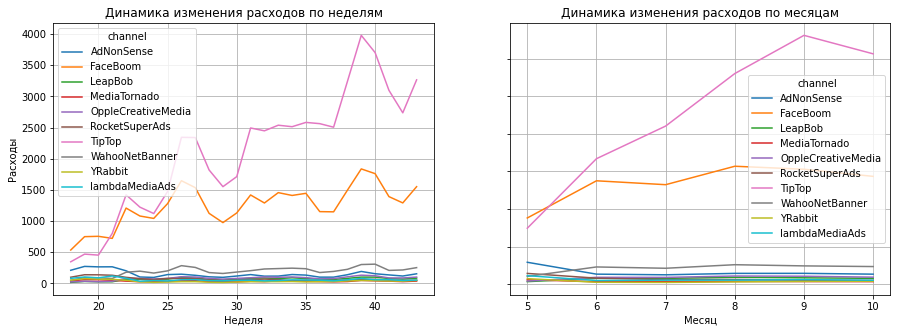

In [23]:
# Построим визуализацию динамики изменения расходов во времени по каждому источнику
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month
costs

# задаём размер сетки для графиков
plt.figure(figsize=(15, 5))

weekly_costs = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')

ax1 = plt.subplot(1, 2, 1)
weekly_costs.plot(grid=True, ax=ax1)
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.title('Динамика изменения расходов по неделям')

month_costs = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')

ax1 = plt.subplot(1, 2, 2)
month_costs.plot(grid=True, ax=ax1, sharey=ax1)
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.title('Динамика изменения расходов по месяцам')

На графиках видно, что расходы на FaceBoom и TipTop постоянно растут. 

На рекламную кампанию AdNonSense расходы уменьшились к июню и дальше держались на одном уровне. Вместо этого увеличели бюджет на WahooNetBanner, конверсия которой оказалась в 2 раза ниже конверсии AdNonSense. 

Расходы на другие рекламные кампании не сильно отличаются друг от друга, они стабильны и держатся на одном уровне. 

### CAC из каждого источника

In [24]:
# Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника
cac_mean = (
    profiles.groupby('channel')['acquisition_cost'].mean()
    .sort_values(ascending=False)
    .reset_index()
)
display(cac_mean)

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


In [25]:
# Узнаем, сколько в среднем стоило привлечение одного пользователя для всего проекта
print('Cредний CAC на одного пользователя для всего проекта:', profiles['acquisition_cost'].mean())

Cредний CAC на одного пользователя для всего проекта: 0.7032778251826568


Самая дорогая стоимость привлечения - у TipTop, она в 2 раза больше чем у следующих за ним FaceBoom и AdNonSense. Все три канала привлечения значительно привышают среднюю стоимость привлечения одного пользователя для всего проекта. 

In [26]:
# объединим таблицы:
ad = channel_users.merge(cac_mean, on='channel', how='left')
ad = ad.merge(ad_channel_cost, on='channel', how='left')
ad = ad[["channel", 'users', 'payer', 'costs', 'acquisition_cost', 'cr']]
ad

,channel,users,payer,costs,acquisition_cost,cr
0,FaceBoom,29144,3557,32445.60,1.113286,12.204914
1,AdNonSense,3880,440,3911.25,1.008054,11.340206
2,lambdaMediaAds,2149,225,1557.60,0.724802,10.469986
3,TipTop,19561,1878,54751.30,2.799003,9.600736
4,RocketSuperAds,4448,352,1833.00,0.412095,7.913669
5,WahooNetBanner,8553,453,5151.00,0.602245,5.296387
6,YRabbit,4312,165,944.22,0.218975,3.826531
7,MediaTornado,4364,156,954.48,0.218717,3.574702
8,LeapBob,8553,262,1797.60,0.210172,3.063253
9,OppleCreativeMedia,8605,233,2151.25,0.250000,2.707728


Подведем итоги изучения рекламных кампаний и расскажем о главном в порядке снижения конверсии: 
- В лидерах почти по всем показателям - FaceBoom, он привлек больше всего пользователей, у него дорогая реклама (1,1 у.е), но и самая высокая конверсия (12,2%). 
- Следующий по размеру конверсии - AdNonSense (11,3%), каждый пользователей стоит около 1 у.е., это почти столько же, как у FaceBoom. Отличает его то, что на рекламную кампанию не стали выделять много денег.
- LambdaMediaAds пока что выигрывает в соотношении цены/качества, за 0,7 у.е. конверсия составляет 10,5%. К сожалению, бюджет на данную кампанию был небольшим, и она привлекла всего 2149 пользователей. 
- TipTop оказался самым дорогим по стоимости привлечения пользователей, целых 2,8 у.е. Однако конверсия не высокая, 9,6%. Расходы на рекламу увеличивали каждый месяц.
- Хочется также выделить WahooNetBanner, он третий по размеру выделяемого бюджета на рекламу и четвертый по стоимости правлечения пользователей. В конце мая на него стали выделять больше денег, но конверсия все равно осталась низкая, всего 5,2 %. 

## Окупаемость рекламы

In [27]:
#Установим момент и горизонт анализа данных.
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [28]:
#уберем из исследования источник бесплатного трафика:
profiles = profiles.query('channel != "organic"')

### Окупаемость рекламы

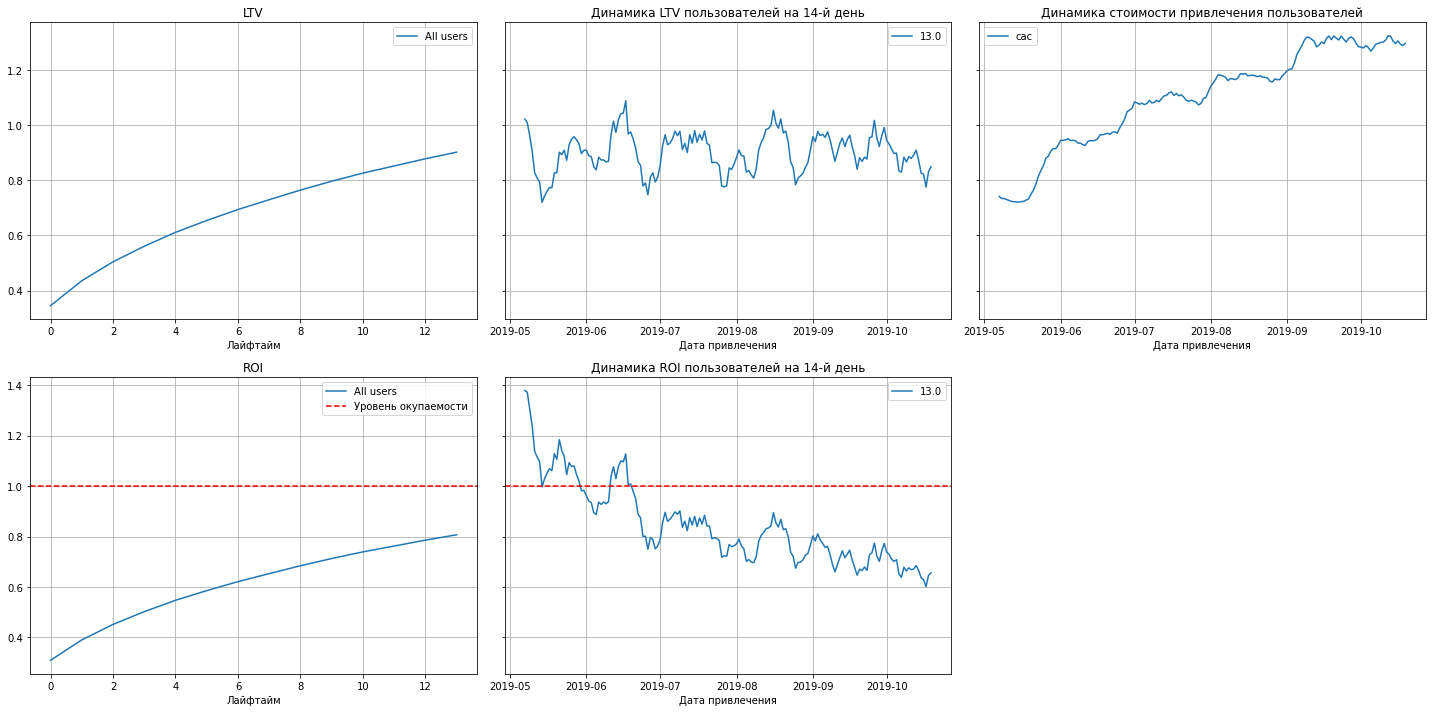

In [29]:
# Оценим общую ситуацию — посмотрим на окупаемость рекламы
# Рассчитаем и визуализируем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы: реклама не окупается в сроки, заложенные в бизнес-плане. Стоимость привлечения пользователей с середины мая до начала июня резко выросла, а потом продолжила свой постепенный рост от месяца к месяцу. Одновременно с ростом стоимости привлечения пользователей падал ROI пользователей на 14-й день. Возможно, дело все-таки в увеличении расходов на рекламу.

### Конверсия пользователей и динамика её изменения

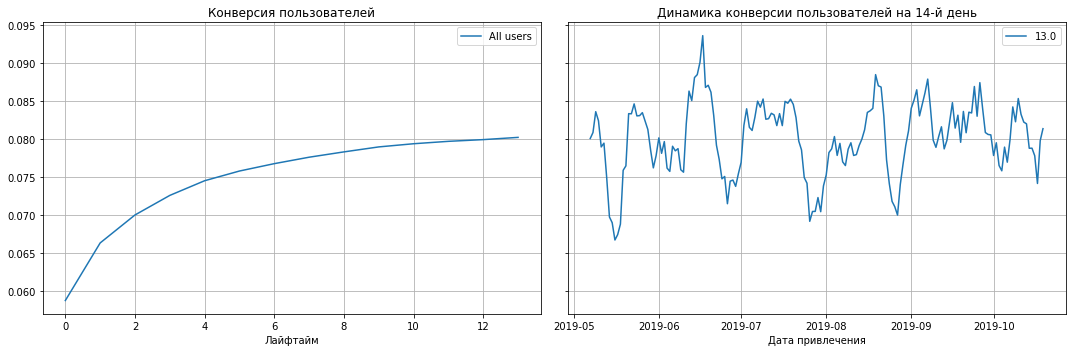

In [30]:
# Проверим конверсию пользователей и динамику её изменения. 
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

График динамики конверсии пользователей на 14 день похож на график изменения расходов на рекламу по неделям, при чем только по каналам FaceBoom и TikTok. Изменения в стоимости рекламы напрямую влияли на конверсию пользователей, это особенно заметно в конце мая и в конце августа. 

### Окупаемость рекламы с разбивкой по устройствам

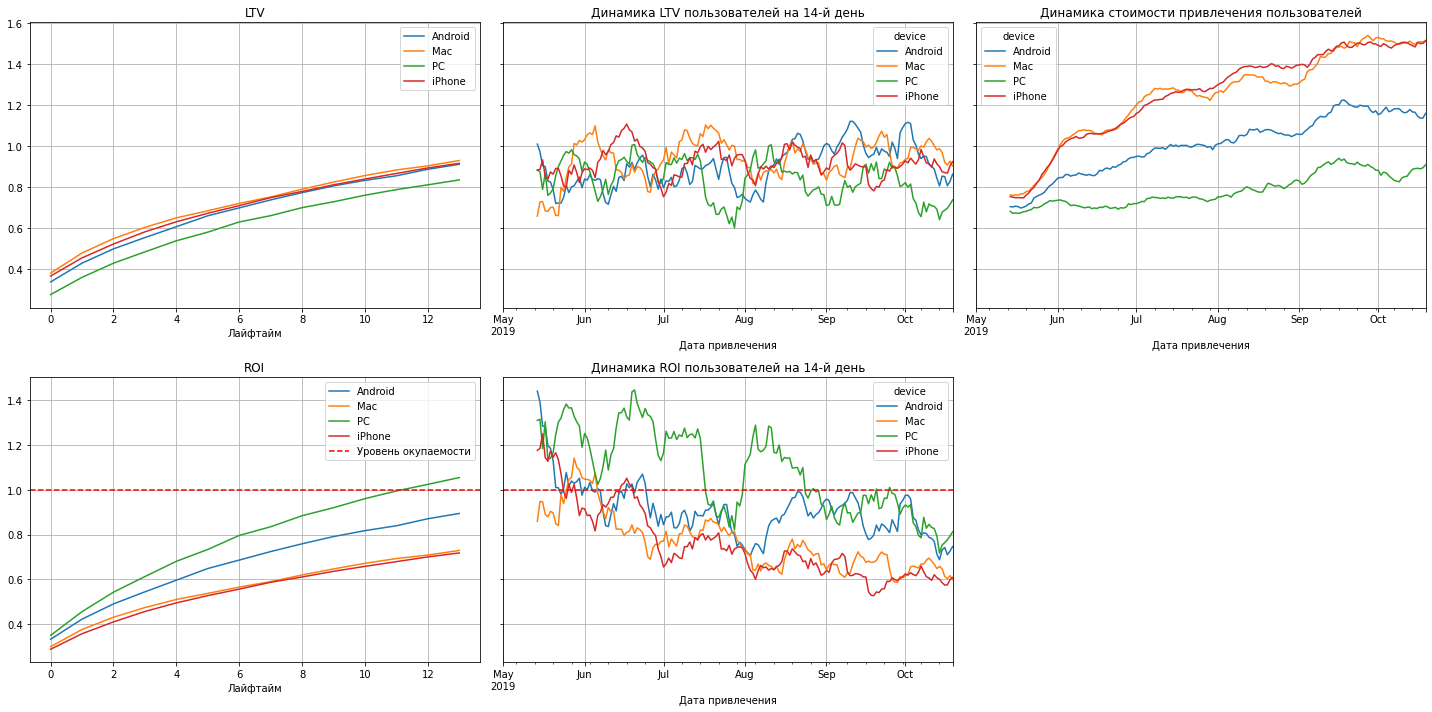

In [31]:
# Проанализируем окупаемость рекламы с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Динамика стоимости привлечения клиентов растет для всех устройств, но самой дорогой реклама оказалась для пользователей Iphone и Mac, а самой дешевой - у пользователей PC. Возможно именно из-за умеренного роста стоимости рекламы, пользователи PC единственные смогли окупиться. 

### Окупаемость рекламы с разбивкой по рекламным каналам

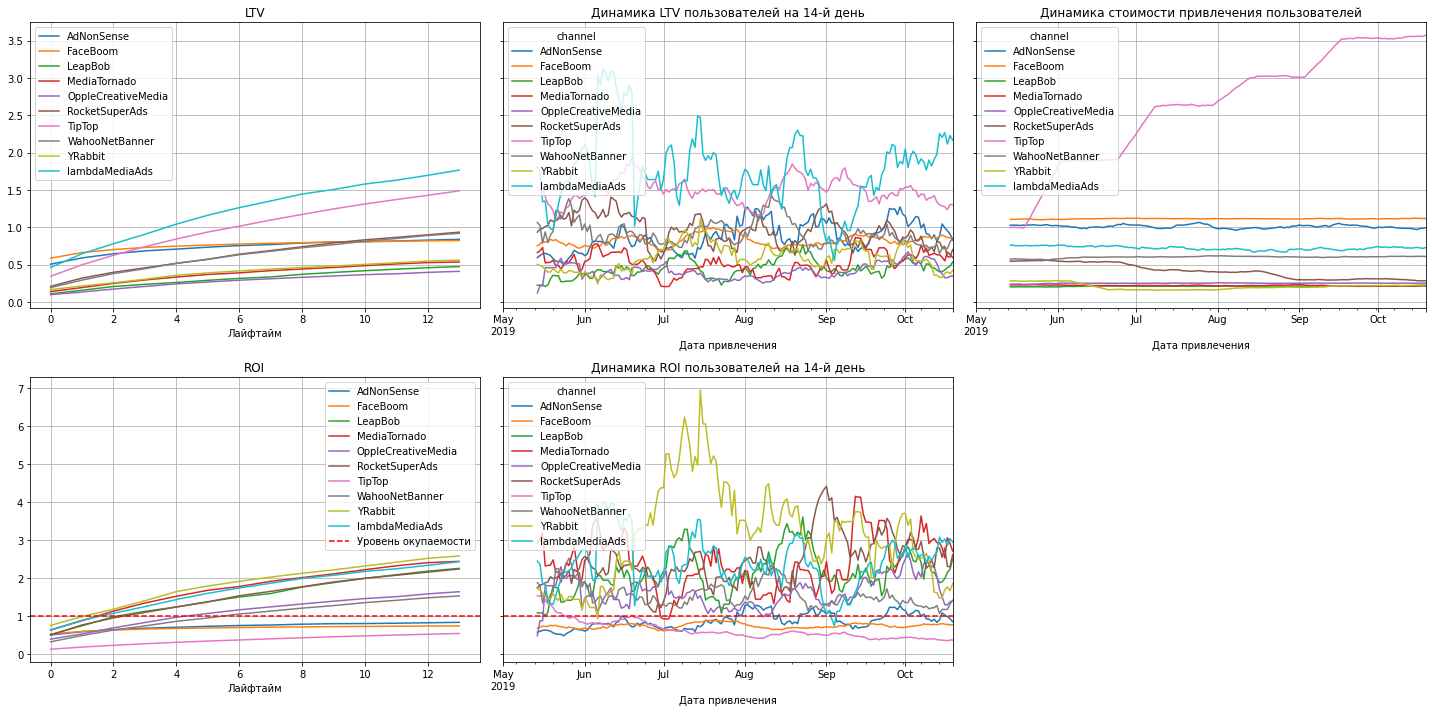

In [32]:
# Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Не окупаются пользователи из AdNonSense и FaceBoom и TipTop. Хороший LTV у LambdaMediaAds. Стоимость привлечения пользователей почти не меняется и стабильна для всех, кроме TikTok, у которого она росла каждый месяц. 

### Окупаемость рекламы с разбивкой по странам

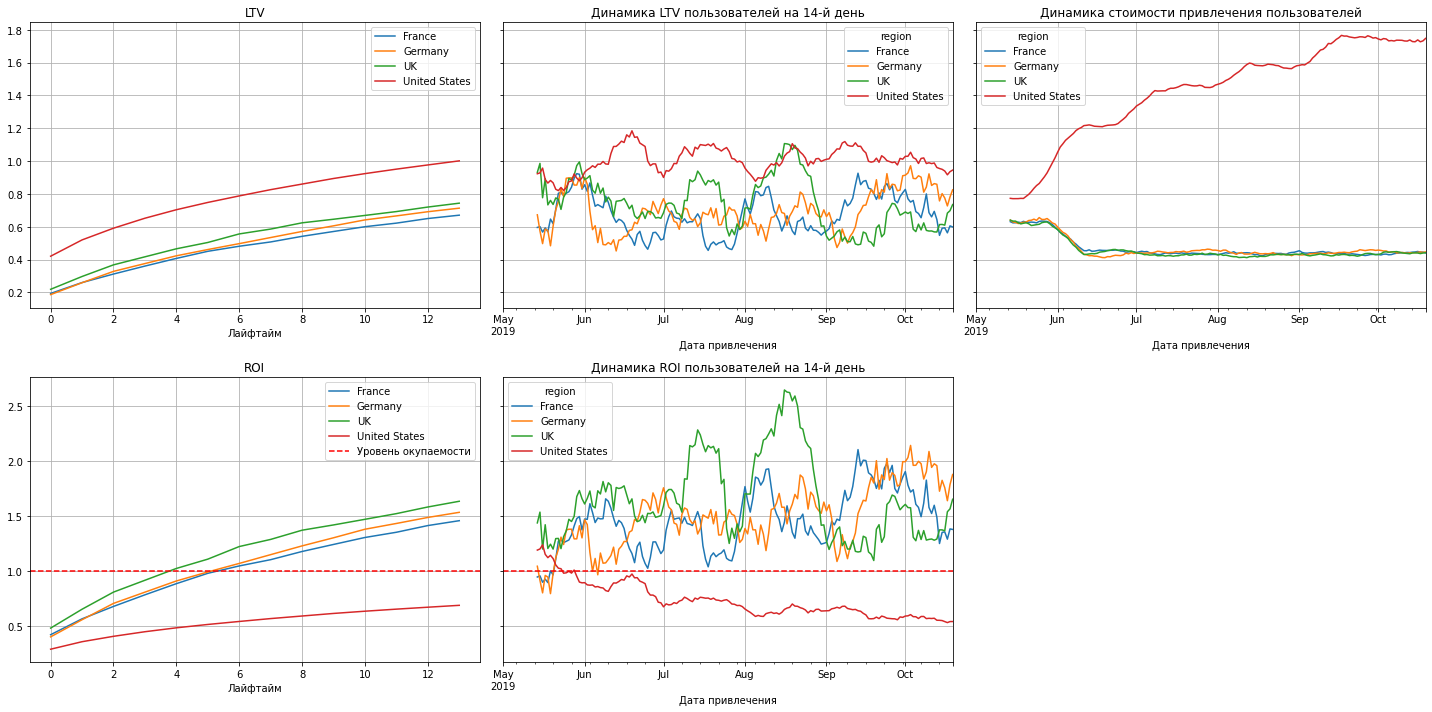

In [33]:
# Проанализируем окупаемость рекламы с разбивкой по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Графики с разбивкой по странам указывают нам на причину неэффективной рекламной кампании: несмотря на высокий LTV, пользователи из США не окупаются и тянут за собой всю кампанию. С конца мая стоимость привлечения клиентов из США взлетела и продолжила расти от месяца к месяцу, а вот стоимость привлечения в Европе упала.

Есть еще одна интересная закономерность: кампании в европейских странах очень похожи в графиках между собой и координально отличаются от трендов США. Проверим распределение рекламных каналов по странам. 

### Распределение рекламных каналов по странам

In [34]:
# Посмотрим на распределение рекламных каналов по странам

channel_region = (
        profiles.query('channel != "organic"')
        .groupby(['channel', 'region'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .sort_values(by='unique_users', ascending = False)
        .reset_index()
    )
display(channel_region) 

,channel,region,unique_users
0,FaceBoom,United States,29144
1,TipTop,United States,19561
2,RocketSuperAds,United States,4448
3,MediaTornado,United States,4364
4,YRabbit,United States,4312
5,OppleCreativeMedia,UK,3052
6,LeapBob,UK,3046
7,WahooNetBanner,UK,3003
8,OppleCreativeMedia,France,2991
9,LeapBob,France,2988


Каналы привлечения в Америке не работают в Европе и наоборот. Именно поэтому рекламные кампании двух континентов так сильно отличаются и не имеют друг с другом общих трендов. 

Больше всего привлекли пользователей из США. Меньше всего пользователей привлекли через LambdaMediaAds AdNonSense.

#### Окупаемость рекламы с разбивкой по каналам в Великобритании

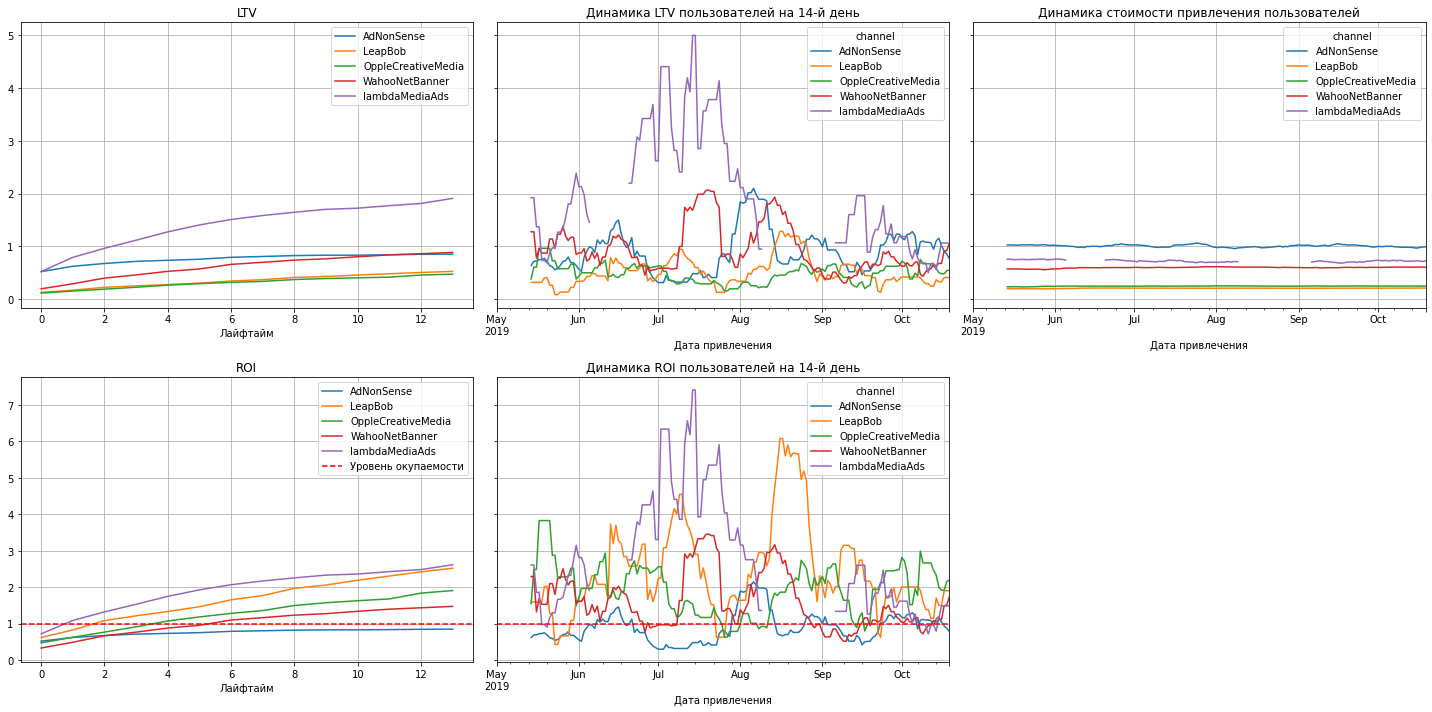

In [35]:
# Проанализируем окупаемость рекламы с разбивкой по каналам привлечения в Великобритании

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "UK"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В рекламных кампаниях Великобритании мы видим:
- LambdaMediaAds - остановка РК в июне и августе, высокий LTV пользователей на 14 день и ROI пользователей на 14 день в июле. Самая успешная по окупаемости кампания. Необходимо изучить настройки РК за июль и попытаться повторить результат. 
- AdNonSense - самая высокая стоимость привлечения, LTV не растет, скорее всего проблема в удержании. Рекламная кампания окупилась только в начале августа и в целом убыточна. Необходимо изучить настройки РК за начало августа и попытаться повторить результат. Также изучить удержание по данному каналу.
- WahooNetBanner - стоимость привлечения стабильная, LTV хорошо растет, высокие пики в середине июля и середине августа, реклама в целом окупается. 
- LeapBob и OppleCreativeMedia имеют почти одинаковые стоимость привлечения и LTV, но у LeapBop выше ROI. 

#### Окупаемость рекламы с разбивкой по каналам в Германии

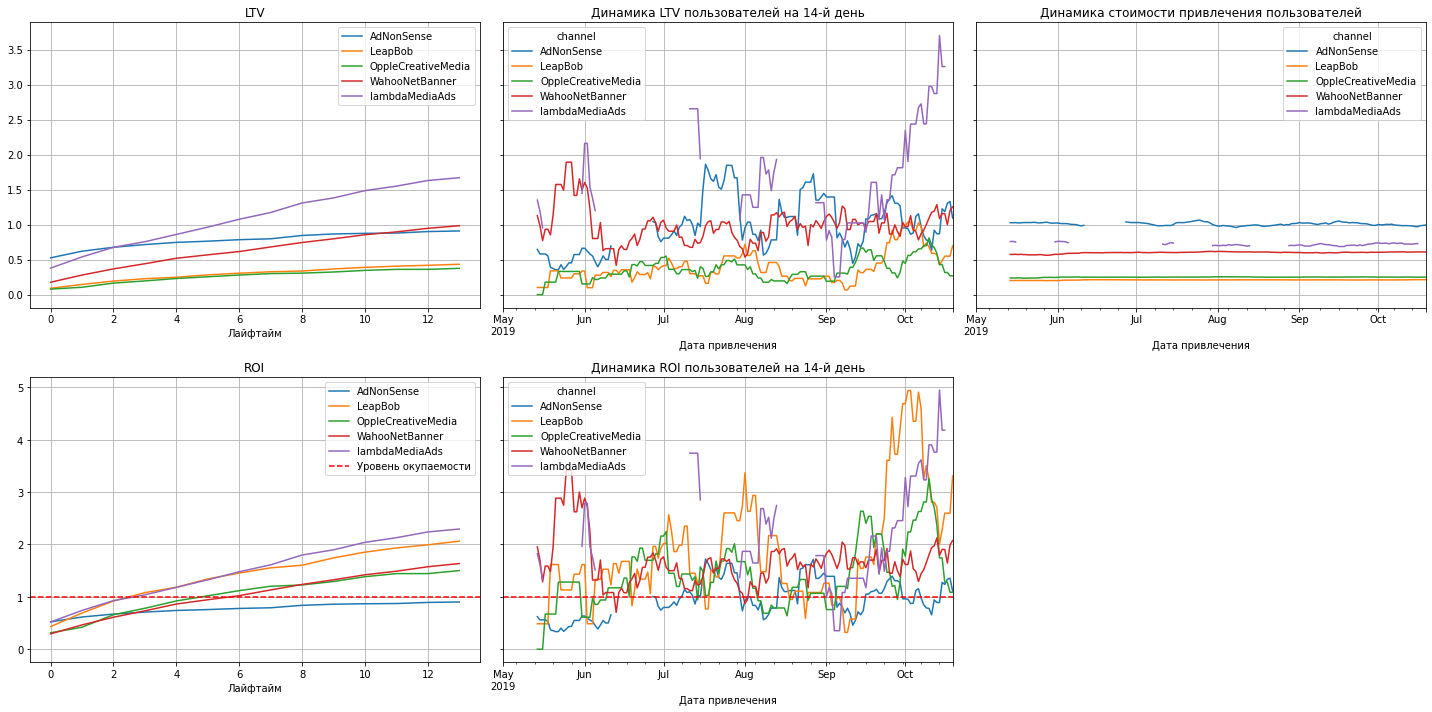

In [36]:
# Проанализируем окупаемость рекламы с разбивкой по каналам привлечения в Германии

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "Germany"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В рекламных кампаниях Германии мы видим:
- LambdaMediaAds - 5 остановок РК за рассматриваемый период. И все равно высокий LTV пользователей на 14 день и ROI пользователей на 14 день. Самая успешная по окупаемости кампания. Хорошие показатели на конец октября. 
- AdNonSense - самая высокая стоимость привлечения, LTV плохо растет. Рекламная кампания окупалась в конце июля и августа, в целом убыточна. Была остановка в июне. Также изучить удержание по данному каналу.
- WahooNetBanner - стоимость привлечения стабильная, LTV хорошо растет, высокий пик в конце мая. Реклама в окупается. 
- LeapBob и OppleCreativeMedia имеют почти одинаковые стоимость привлечения и LTV, но у LeapBop выше ROI. 

#### Окупаемость рекламы с разбивкой по каналам во Франции

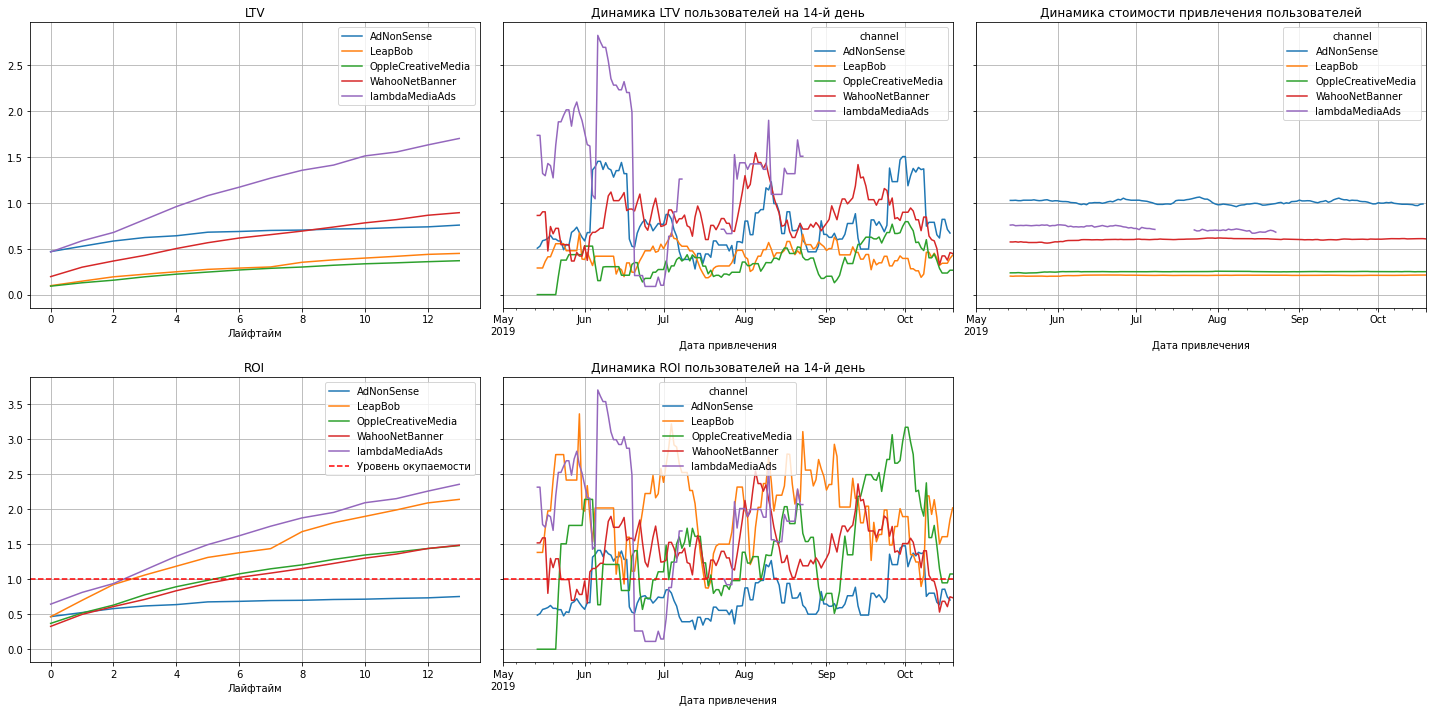

In [37]:
# Проанализируем окупаемость рекламы с разбивкой по каналам привлечения во Франции

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "France"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В рекламных кампаниях Франции мы видим:
- LambdaMediaAds - остановка РК в июле и в августе полное отключение. Высокий LTV пользователей на 14 день и ROI пользователей на 14 день в мае и июне. Самая успешная по окупаемости кампания. Необходимо изучить настройки РК за первую половину июня и попытаться повторить результат. 
- AdNonSense - самая высокая стоимость привлечения, LTV плохо растет, скорее всего проблема в удержании. Рекламная кампания окупилась только в начале июня и в конце сентября, в целом убыточна. Необходимо изучить удержание по данному каналу.
- WahooNetBanner - стоимость привлечения стабильная, LTV хорошо растет, высокие пики в начале августа, реклама в целом окупается. 
- LeapBob и OppleCreativeMedia имеют почти одинаковые стоимость привлечения и LTV, но у LeapBop выше ROI. 

#### Окупаемость рекламы с разбивкой по каналам в США

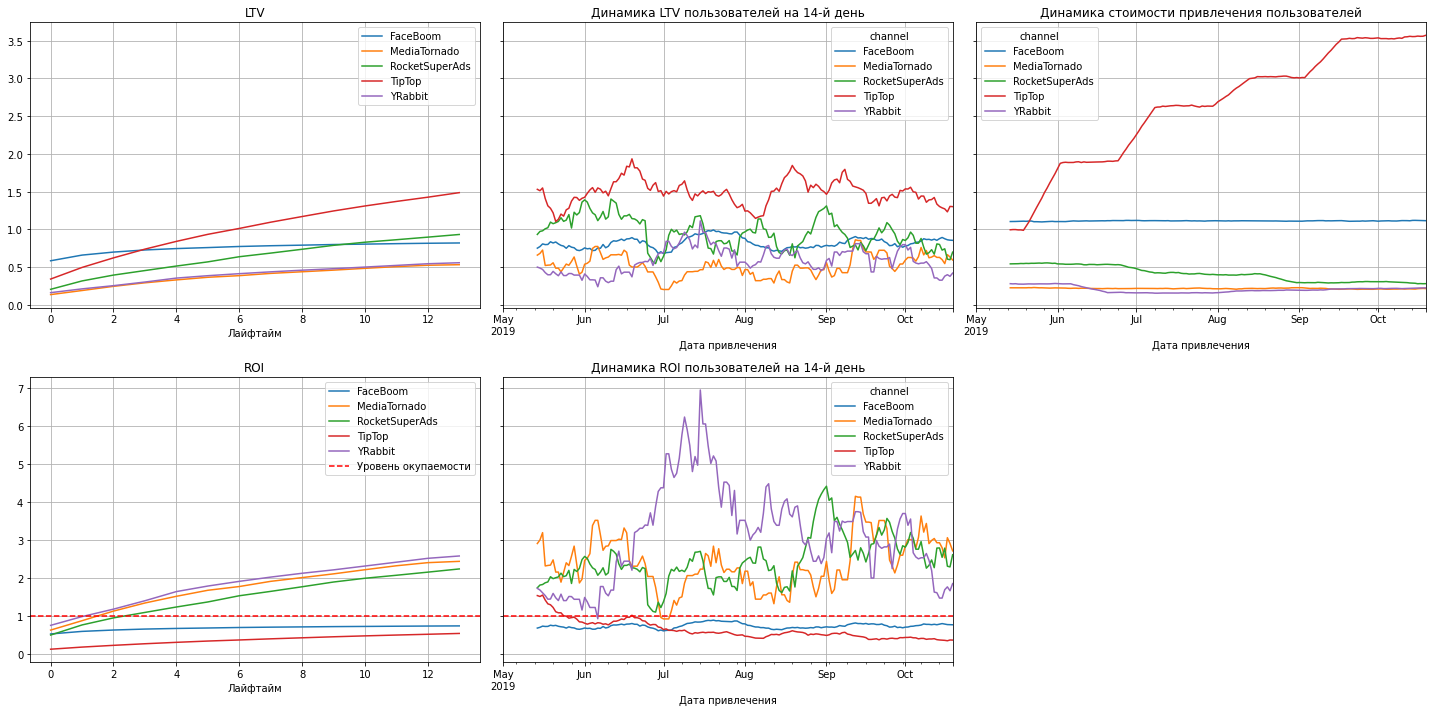

In [38]:
# Проанализируем окупаемость рекламы с разбивкой по каналам привлечения в США

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В рекламных кампаниях США мы видим:
- TipTop - самый дорогой канал привлечения, ежемесячное увеличение стоимости привлечения пользователей, самый выскоий LTV и самый низкий ROI, реклама убыточная. 
- FaceBoom - дорогой канал привлечения, стоимость привлечения стабильна, LTV плохо растет, реклама не окупается. Возможно, проблема в удержании. 
- RocketSuperAds - стоимость привлечения клиентов снижается каждые 2 месяца, LTV хорошо растет, реклама окупается. 
- MediaTornado и YRabbit имеют почти одинаковые стоимость привлечения. Высокий пик в динамике ROI в июле у YRabbit. 

#### Промежуточный вывод

В разбивке рекламных кампаний по странам Европы видно, что самая успешная реклама - на канале LambdaMediaAds. Проблема в том, что показ рекламы постоянно прерывается во всех странах Европы. Именно поэтому LambdaMediaAds привлекла меньше всего пользователей. Также прослеживается проблема в AdNonSense - у них самая высокая стоимость привлечения, LTV не растет, Рекламная кампания не окупается. Скорее всего проблема в удержании. 

В рекламных кампаниях США мы нашли 2 главные проблемы TipTop - самый дорогой канал привлечения, с ежемесячным увеличением стоимости привлечения пользователей, с самым выскоим LTV и самым низким ROI, реклама убыточная. И FaceBoom со стабильностью в стоимости, LTV и окупаемостью. Возможно, проблема в удержании. Именно эти два канала привлечения тянут за собой вниз всю эффективность рекламы по всем источникам и странам. 

### Конверсия пользователей с разбивкой по странам

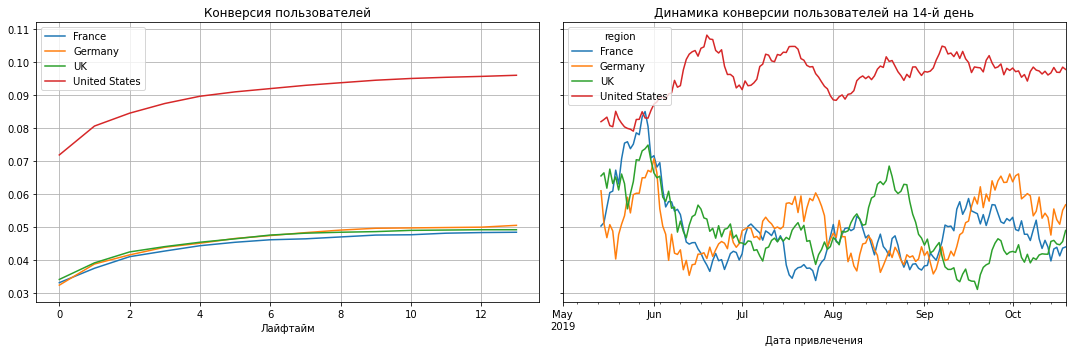

In [39]:
# Проверим конверсию пользователей и динамику её изменения с разбивкой по рекламным каналам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,  window=14)

В США самая высокая конверсия. 

### Удержание пользователей с разбивкой по странам

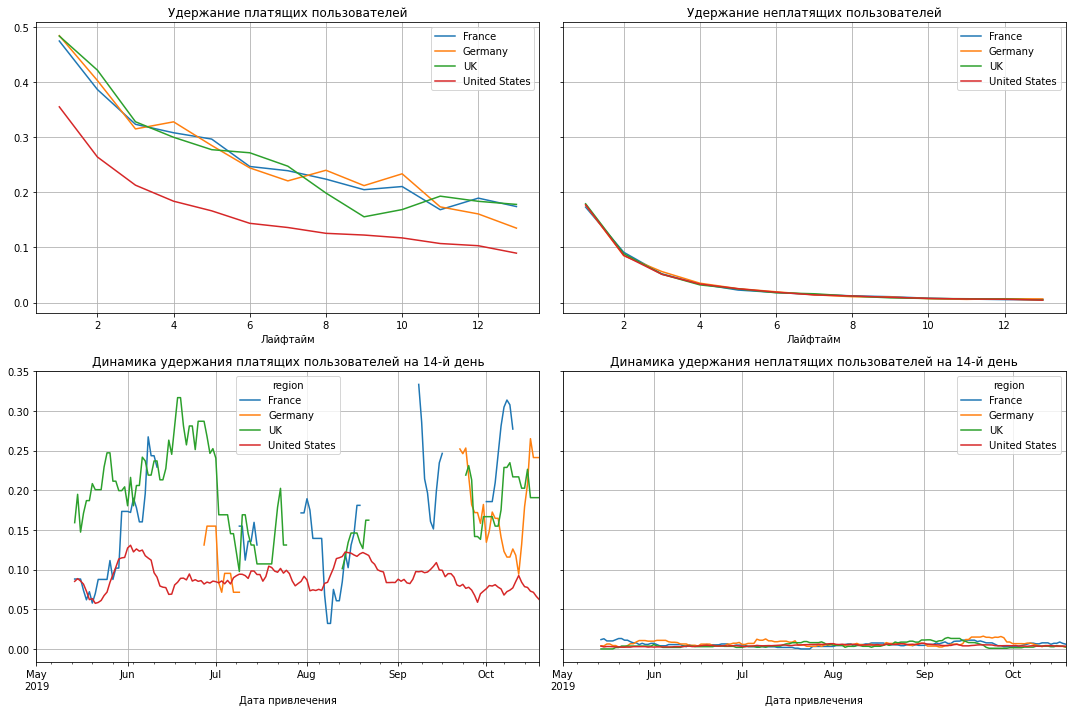

In [40]:
# Посмотрим графики удержаниея пользователей
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)


plot_retention(retention_grouped, retention_history, horizon_days, window=14)

Проблема в рекламной кампании США - в низком удержании пользователей. 

### Конверсия пользователей с разбивкой по каналам

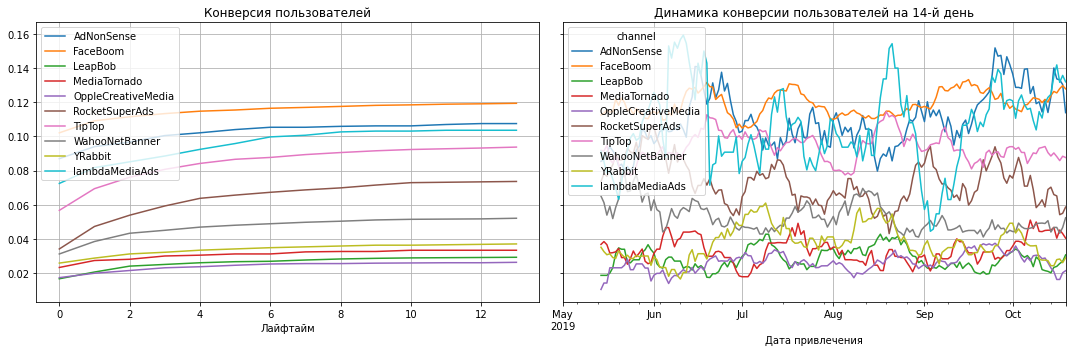

In [41]:
# Проверим конверсию пользователей и динамику её изменения с разбивкой по рекламным каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

Самая большая конверсия у FaceBoom, AdNonSense и lambdaMediaAds. OppleCreativeMedia, LeapBob и MediaTorndo - в аутсайдерах. 

### Удержание пользователей с разбивкой по каналам

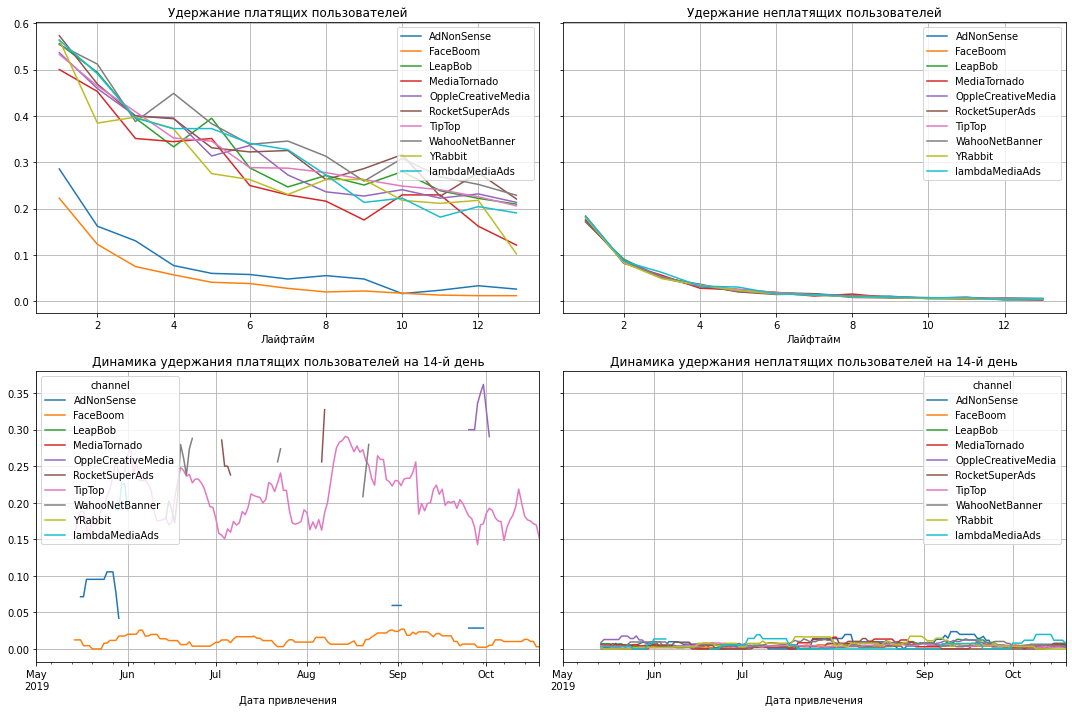

In [42]:
# Посмотрим графики удержаниея пользователей
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

В графике удержания платящих пользователей четко видны два отстающих - AdNonSense и FaceBoom, у них очень низкий коэффицент удержания. Необходимо выяснить причину: возможно после совершения покупки что-то пошло не так? Сможет ли какой-нибудь бонус вернуть пользователя в приложение?

FaceBoom стабильно низкая динамика удержания, у TipTop Она скачет - прямая корреляция с графиком разходов на рекламу. 

### Конверсия пользователей с разбивкой по устройствам

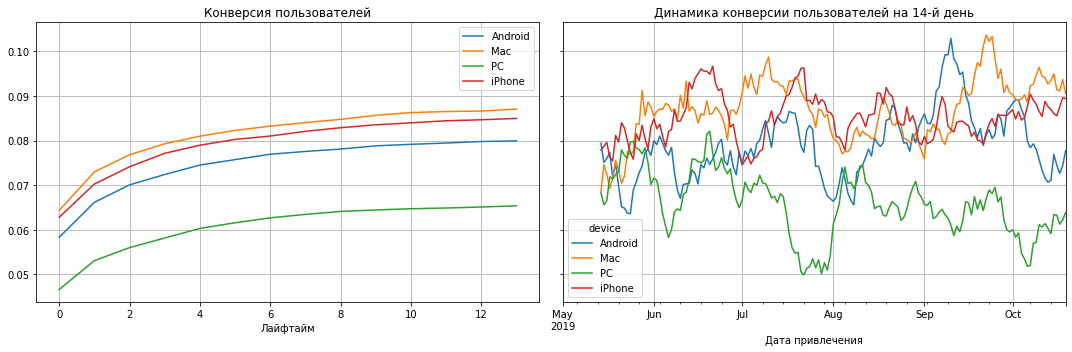

In [43]:
# Проверим конверсию пользователей и динамику её изменения с разбивкой по рекламным каналам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,  window=14)

Хуже всего конвертируются в покупателей пользователи PC.

### Удержание пользователей с разбивкой по устройствам

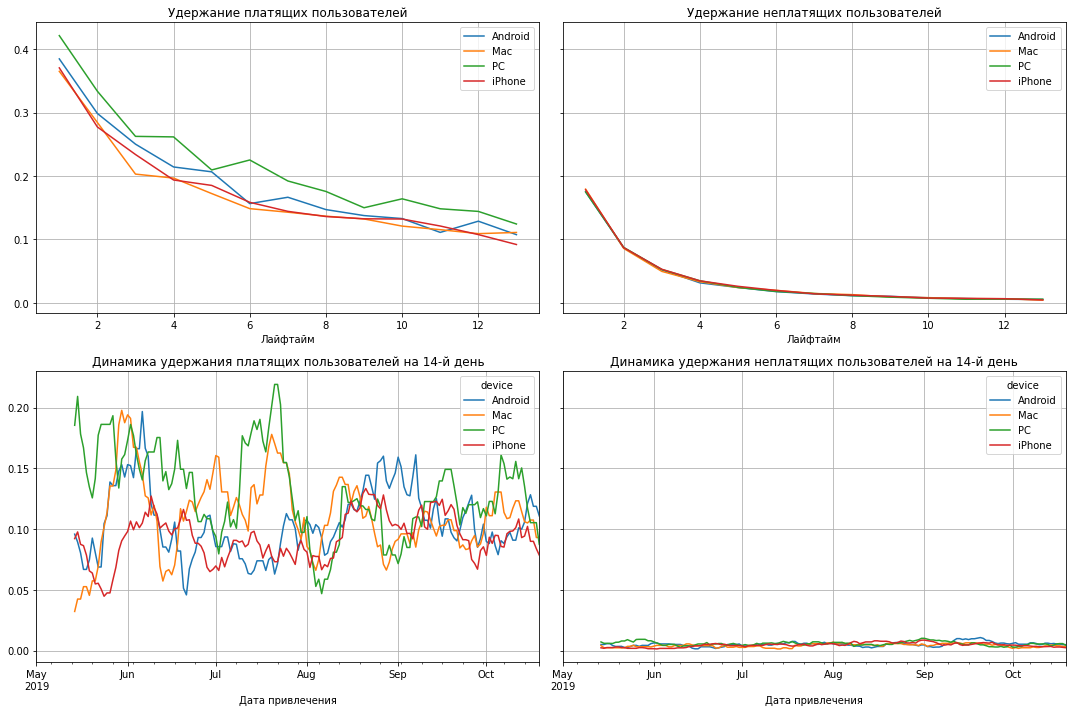

In [44]:
# Посмотрим графики удержаниея пользователей
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

Удержание на всех устройствах почти одинаковое. Это значит, что устройства на провальность рекламы точно не влияют. 

## Общие выводы

Реклама, направленная на привлечение пользователей в целом, не окупается в заложенные в бизнес-плане сроки.

Стоимость привлечения пользователей с середины мая до начала июня резко выросла, а потом продолжила свой постепенный рост от месяца к месяцу. Одновременно с ростом стоимости привлечения пользователей падала окупаемость пользователей на 14-й день. 

Компания использует две стратегии привлечения пользователей, завязанных на регионе первого посещения. Это стабильно не активное привлечение пользователей в европейских странах, которое хорошо окупается, и динамичный и убыточный захват рынка США, который приносит компании новых пользователей, но портит общую статистику по всем рекламным кампаниям приложения. И именно реклама американского канала TikTok так сильно повлияла на общие результаты. 

### Европа
В Европе можно выделить два канала привлечения пользователей: AdNonSense и LambdaMediaAds (конверсии  11,3% и 10,5% соответственно). При сравнительно небольших затратах на рекламу эти каналы дают хорошую конверсию. 

Несмотря на эффективность, пользователей из Европы приходит мало. Связано это с низким бюджетом рекламной кампании и тем, что она непостоянная. Если направить на LambdaMediaAds больше денег, он сможет принести больше клиентов.

У AdNonSense есть проблема с удержанием пользователей, и чтобы стимулировать данных пользователей возвращаться в приложение, необходимо понять причину плохого удержания и добавить персональные акции. 

Хочется также выделить WahooNetBanner, он третий по размеру выделяемого бюджета на рекламу и четвертый по стоимости привлечения пользователей. В конце мая на него стали выделять дополнительный бюджет, но конверсию это не улучшило (всего 5,2 %).

### США
Вторая стратегия - США. Больше всего в приложение приходят пользователи из стран США, и именно на США приходится больше всего платящих пользователей. Лидеры данного региона:  TipTop и FaceBoom, на них потратили в разы больше денег, чем на другие каналы привлечения. Не удивительно, что именно эти каналы привели больше всего пользователей.

FaceBoom, привлек больше всего пользователей, у него дорогая реклама (1,1 у.е), и самая высокая конверсия (12,2%) и очень низкое удержание.

TipTop оказался самым дорогим по стоимости привлечения пользователей, целых 2,8 у.е., однако конверсия невысокая (9,6%). Расходы на рекламу увеличивали каждый месяц, но окупаемость только падала. Начало мая - единственное время, когда реклама хоть как-то окупалась. 

### Европа:
- Для увеличения числа пользователей yеобходимо увеличить рекламный бюджет для европейских стран. 
- Особое внимание уделить LambdaMediaAds - у них самые качественные покупатели и высокая конверсия, тут бюджет можно не жалеть и ни в коем случае не останавливать рекламную кампанию. Также предложить дополнительные бонусы покупателям для того, чтобы они задержались в приложении еще дольше. 
- Оптимизируйте стратегию удержания клиентов для каналов AdNonSense, оно очень низкое. Продумайте бонусную систему, чтобы превратить их в постоянных покупателей и сэкономить на привлечении новых клиентов.
- Проверить, с чем связан успех рекламной кампании LeapBob в августе в Великобритании, в октябре в Германии и попытаться ее повторить. FaceBoom стабильно низкая динамика удержания, у TipTop Она скачет - прямая корреляция с графиком расходов на рекламу.

Пользователи iPhone и Mac чаще других становятся клиентами приложения и покупают продукт. Динамика стоимости привлечения клиентов растет для всех устройств, но самой дорогой реклама оказалась для пользователей Iphone и Mac, а самой дешевой - у пользователей PC. Возможно именно из-за умеренного роста стоимости рекламы, пользователи PC единственные смогли окупиться.

## Рекомендации для отдела маркетинга

### США: 
- Оптимизируйте стратегию удержания клиентов для FaceBoom, она крайне низкая. Продумайте бонусную систему, чтобы превратить их в постоянных покупателей и сэкономить на привлечении новых клиентов. Если стратегия не сработает - прекратить рекламу на данном канале. 
- Это же необходимо сделать с клиентами, пришедшими из TipTop - они приносят больше всего прибыли: придумайте для них особую бонусную систему и т.п. для того, чтобы они задерживались в приложении еще дольше.
- Откатите настройки рекламной кампании и бюджет TipTop до настроек начала мая, именно в то время она еще окупалась.
- Часть освободившихся средств направить на RocketSuperAds, у них достаточно высокая конверсия и низкая стоимость привлечения пользователей. 